In [274]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import filters, feature
from skimage.feature import hessian_matrix, hessian_matrix_eigvals

In [8]:
def plot_images(*images):
    images = list(images)
    n = len(images)
    fig, ax = plt.subplots(ncols=n, sharey=True)
    fig.set_size_inches(12,4)
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap='gray')
        ax[i].axis('off')
    plt.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.97)
    plt.show()

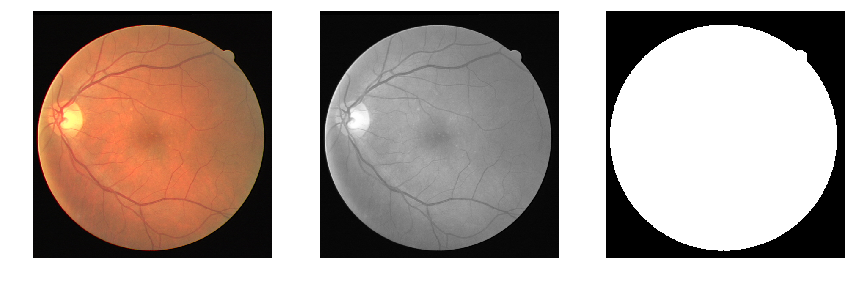

In [275]:
img = cv2.imread('data/DRIVE/training/images/21_training.tif')
mask = plt.imread('data/DRIVE/training/mask/21_training_mask.gif') #cause cv2 can't read gifs :X
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

plot_images(rgb, gray, mask)

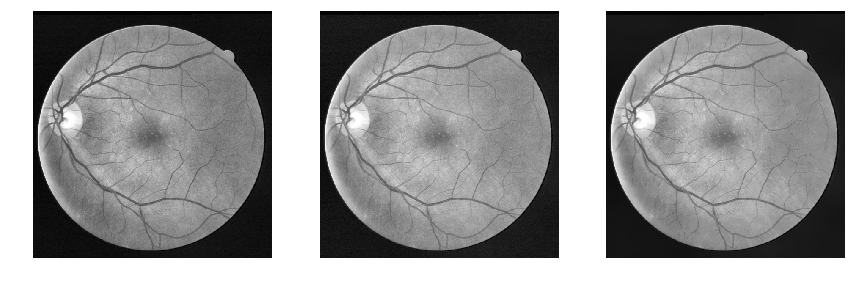

In [276]:
# CLAHE (Contrast Limited Adaptive Histogram Equalization)
#adaptive histogram equalization is used. In this, image is divided into small blocks called "tiles" 
#(tileSize is 8x8 by default in OpenCV). Then each of these blocks are histogram equalized as usual. 
#So in a small area, histogram would confine to a small region (unless there is noise). 
#If noise is there, it will be amplified. To avoid this, contrast limiting is applied. 
#If any histogram bin is above the specified contrast limit (by default 40 in OpenCV), 
#those pixels are clipped and distributed uniformly to other bins before applying histogram equalization. 
#After equalization, to remove artifacts in tile borders, bilinear interpolation is applied

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
hist_eq = clahe.apply(gray)

gamma = 1.2
# build a lookup table mapping the pixel values [0, 255] to
# their adjusted gamma values
invGamma = 1.0 / gamma
table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
# apply gamma correction using the lookup table
gamma_corrected = cv2.LUT(hist_eq, table)

# fast cv2 denoising
denoised = cv2.fastNlMeansDenoising(gamma_corrected.astype('uint8'), None, 3,7)

plot_images(hist_eq, gamma_corrected, denoised)

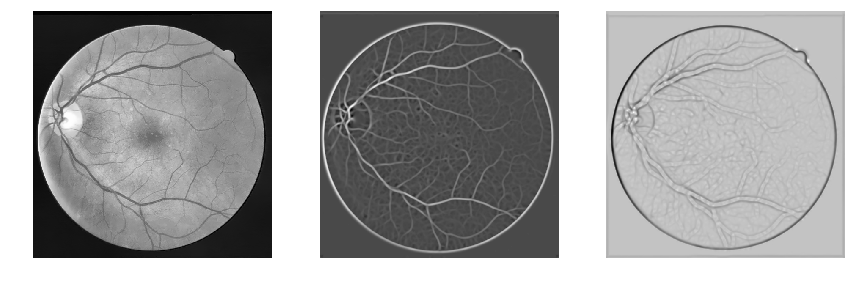

In [277]:
def detect_ridges(gray, sigma=1.0):
    H_elems = hessian_matrix(gray, sigma=sigma, order='rc')
    maxima_ridges, minima_ridges = hessian_matrix_eigvals(H_elems)
    return maxima_ridges, minima_ridges

a, b = detect_ridges(denoised, sigma=3.0)

plot_images(denoised, a, b)

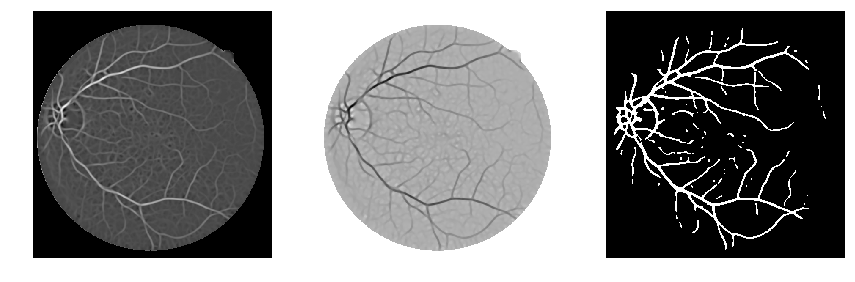

In [283]:
a = a + (a.min() * (-1)) #just some normalization stuff, because we were going negative
a = a/a.max()
a = a*255
a = a.astype('uint8') # basic conversion for cv2 operations to work properly

#applying a mask
masked = np.zeros(a.shape)
masked[mask > 0] = a[mask > 0]

def cover_ratio(transformed, label): #what part of white pixels were actually covered
    return np.sum(transformed * label)/np.sum(label)

def accuracy(transformed, label):
    return (transformed == label).sum()/(label.shape[1]*label.shape[0])

median  = cv2.medianBlur(masked.astype('uint8'), 5)

median = 255-median

ret,thresh = cv2.threshold(median.astype('uint8'),165,255,cv2.THRESH_BINARY_INV)

plot_images(masked, median, thresh)

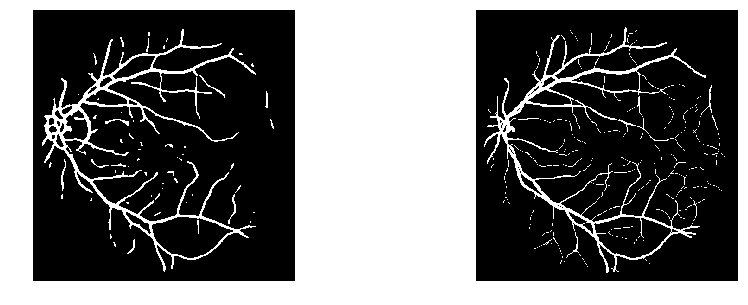

0.9597405746151049

In [279]:
labeled = plt.imread('data/DRIVE/training/1st_manual/21_manual1.gif')
plot_images(thresh, labeled)
accuracy(thresh, labeled)
#cover_ratio(thresh, labeled)

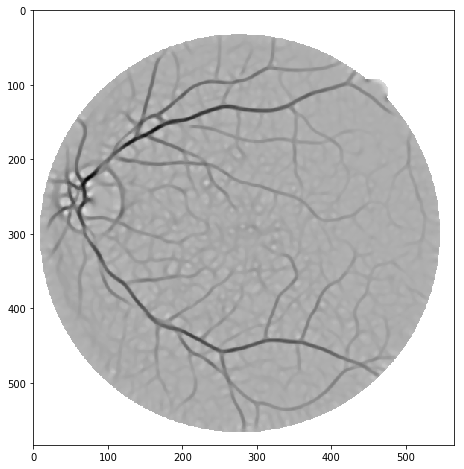

In [284]:
plt.figure(figsize=(8,8))
plt.imshow(median, cmap='gray')